# Rolling risk control - an example in depth estimation task

In this notebook, we apply rolling risk control (RRC) in a depth estimation task to construct pixel-wise prediction intervals with a controlled error. Specifically, we control two risks: the image miscoverage (`ImageMiscoverageLoss`) and the poor coverage (`PoorCenterCoverageLoss`) risks. By controlling the two risks, we guarantee that the average coverage rate is controlled at the desired level, and that the coverage at the center of the image does not fall below $60\%$ for at least $90\%$ of the timestamps.

We see that RRC controls both risks at the desired levels, as guaranteed by Theorem 2.

**Important:** you should use a model that was pre-trained on KITTI dataset to obtain reasonable reasults

# Imports

In [1]:
import json
import os
import sys
from typing import List
import seaborn as sns
import matplotlib
import numpy as np
import torch
from tqdm import tqdm
sys.path.insert(0, "../")
from src.calibration.online_calibration import OnlineCalibration
from src.calibration.parameters_free_online_calibration import ParameterFreeOnlineCalibration
from src.calibration.rolling_risk_control import RollingRiskControlWithMultipleRisks
from src.calibration.set_constructing_functions.set_constructing_function import MaxAggregation, PredictionIntervalMatrixConstructingFunctionWithMeanAndStd

from src.calibration.stretching_functions.stretching_functions import ExponentialStretching
from src.data_utils.data_utils import DataType
from src.data_utils.datasets.depth_dataset import DepthDataset
from src.losses import ImageMiscoverageLoss, PoorCenterCoverageLoss
from src.models.abstract_models.online_learning_model import OnlineLearningModel
from src.models.image_to_image_models.depth_models.Leres.data.multi_dataset import MultiDataset
from src.models.image_to_image_models.depth_models.depth_uq_model import DepthUQModel
from src.uncertainty_quantifiers.prediction_intervals_matrix import PredictionIntervalsMatrixCollection
from src.utils import set_seeds, create_folder_if_it_doesnt_exist




font = {'size'   : 16}

matplotlib.rc('font', **font)

device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)


import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("seaborn").setLevel(logging.WARNING)
logging.getLogger("sns").setLevel(logging.WARNING)


set_seeds(0)

%load_ext autoreload
%autoreload 2

# Definitions

In [2]:
# general definitions

losses_to_control = [
                        ImageMiscoverageLoss(),  # image miscoverage loss - the percentage of uncovered pixels.
#                         PoorCenterCoverageLoss(0.6)  # a loss - indicating when the center coverage falls below 60%.
]  
alphas = [
        0.2,  # for the ImageMiscoverageLoss
#         0.1  # for the PoorCenterCoverageLoss
]

gammas=[
        0.1,
#         0.1
       ]

# dataset definitions
dataset_name = 'KITTI'
base_data_path = "../src/datasets/real_data/depths"
annotations_path = "annotations/train_annotations_onlyvideos.json"
max_data_size = 2000
test_ratio = 0.2
validation_ratio = 0.2


# depth regressor model definitions
trained_model_dir = "../saved_models/Leres"
backbone = 'res101' # either res50 or res101
base_save_path = '..'

# std model definitions
std_method = 'previous_residual_with_alignment'  # either baseline, residual_magnitude or previous_residual_with_alignment.


# calibration scheme definitions

stretching = ExponentialStretching()
aggregation = MaxAggregation()  # need to aggregate the parameters used to control the two losses

# Initialize **dataset**, **model** and **calibration scheme**

In [3]:
dataset = DepthDataset(base_data_path, annotations_path, dataset_name, max_data_size, 0.6,
                        test_ratio, validation_ratio, DataType.Real, device)

In [4]:
trained_model_path = os.path.join(trained_model_dir, f"{backbone}.ph")
model = DepthUQModel(trained_model_path, backbone, std_method, device, base_save_path=base_save_path)

loading checkpoint ../saved_models/Leres\res101.ph


In [5]:
set_constructing_function = PredictionIntervalMatrixConstructingFunctionWithMeanAndStd(stretching, aggregation)
calibration_scheme = RollingRiskControlWithMultipleRisks(gammas=gammas,
                                           alphas=alphas,
                                           set_constructing_function=set_constructing_function,
                                           losses=losses_to_control,
                                           )

# Offline train

In [6]:
training_epochs = 60
offline_train_timestamps = dataset.get_offline_train_timestamps()
model.offline_train(dataset, offline_train_timestamps, epochs=training_epochs)

state in path ..\saved_models\KITTI\depth_qr_backbone=res101_epoch=60.pth: does exist: True
loading model: depth_qr_backbone=res101 for dataset KITTI at epoch 60
successfully loaded model depth_bb=res101_std=previous_residual_with_alignment for data KITTI at epoch 60


# Online inference

In [7]:
def online_inference(model: OnlineLearningModel, calibration_scheme: OnlineCalibration,
                     dataset: DepthDataset,
                     timestamps: List[int], device):
    
    uncertainty_set_collection = PredictionIntervalsMatrixCollection(len(timestamps), device, dataset.scaler, 
                                                                     dataset.image_width, dataset.image_height)
    for curr_timestamp in tqdm(timestamps):
        inference_sample = dataset.get_inference_sample(curr_timestamp)
        with torch.no_grad():
            model_prediction = model.predict(inference_sample)
            calibrated_uncertainty_set = calibration_scheme.calibrate(inference_sample, model_prediction)
            uncertainty_set_collection.add_uncertainty_sets(calibrated_uncertainty_set)

            labeled_inference_sample = dataset.get_labeled_inference_sample(curr_timestamp)
            calibration_scheme.update(labeled_inference_sample, model_prediction, calibrated_uncertainty_set, curr_timestamp)

        train_sample = dataset.get_train_sample(curr_timestamp)
        model.online_fit(train_sample, labeled_inference_data_sample=labeled_inference_sample)
    
    return uncertainty_set_collection


In [8]:
train_timestamps, validation_timestamps, test_timestamps = dataset.get_data_timestamps()

print("Running on training set...")
online_inference(model, calibration_scheme, dataset, train_timestamps, device)
print("Running on validation set...")
online_inference(model, calibration_scheme, dataset, validation_timestamps, device)
if isinstance(calibration_scheme, ParameterFreeOnlineCalibration):
    calibration_scheme.set_hyperparameters_on_validation_set(validation_timestamps)
print("Running on test set...")
calibrated_intervals = online_inference(model, calibration_scheme, dataset, test_timestamps,
                 device)

0it [00:00, ?it/s]
  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Running on training set...
Running on validation set...


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Running on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:35<00:00,  2.28s/it]


Input Frame (RGB)


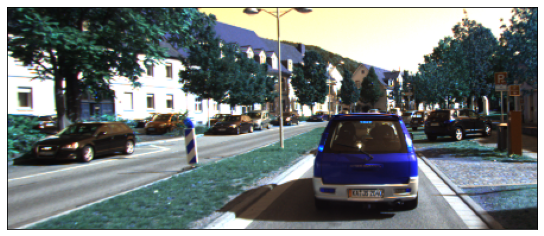

Ground Truth Depth


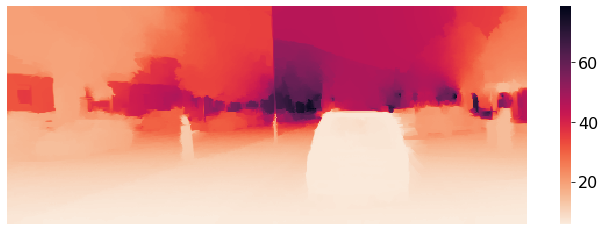

Estimated Depth


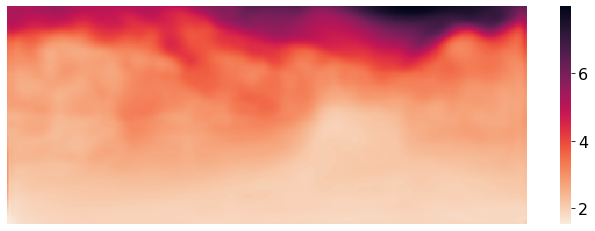

Uncertainty Size


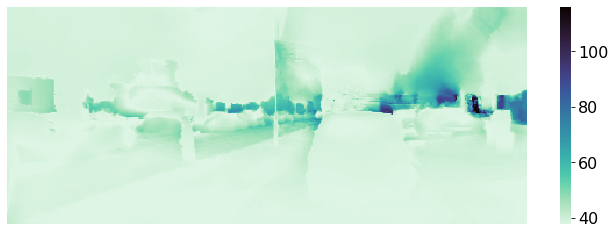

In [16]:
from matplotlib import pyplot as plt
import cv2
meters_factor = 1 / 256
starting_test_time = test_timestamps[0]

with open(os.path.join(base_data_path, dataset_name, annotations_path), 'r') as load_f:
    annotations = json.load(load_f)
    
time = test_timestamps[-1]

idx = time - starting_test_time

sample = dataset.get_labeled_inference_sample(time)

rgb_im = cv2.imread(f'{base_data_path}/{annotations[time]["rgb_path"].strip("/")}', -1)
depth_im = cv2.imread(f'{base_data_path}/{annotations[time]["depth_path"].strip("/")}', -1) * meters_factor
augmentation_info = sample.augmentation_info
estimated_depth_im = calibrated_intervals[idx].estimated_means
intervals = calibrated_intervals[idx].intervals
intervals_im = (intervals[..., 1] - intervals[..., 0]).squeeze() / sample.scaling_factor * meters_factor
intervals_im = intervals_im.cpu().numpy()#.astype(np.uint16)


def display_heatmap(image, title,save_dir=None, **kwargs):
    f, ax = plt.subplots(figsize=(12, 4))
    ax = sns.heatmap(image, ax=ax, **kwargs)
    ax.set_aspect("equal")
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    ax.tick_params(bottom=False)
    ax.tick_params(left=False)
    print(title)
    if save_dir is not None:
        create_folder_if_it_doesnt_exist('plots/depth_experiment_figures')
        plt.savefig(f"plots/depth_experiment_figures/{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

flip_flg, resize_size, crop_size, pad = augmentation_info.flip_flg, augmentation_info.resize_size,\
                                    augmentation_info.crop_size, augmentation_info.pad
resized_depth_im = MultiDataset.flip_reshape_crop_pad(depth_im, flip_flg, resize_size, crop_size, pad, 0)
resized_rgb_im = MultiDataset.flip_reshape_crop_pad(rgb_im, flip_flg, resize_size, crop_size, pad, 0)

resized_depth_im = resized_depth_im[pad[0]: -1-pad[1], pad[2]: -1-pad[3]]
estimated_depth_im = estimated_depth_im[pad[0]: -1-pad[1], pad[2]: -1-pad[3]]
intervals_im = intervals_im[pad[0]: -1-pad[1], pad[2]: -1-pad[3]]
resized_rgb_im = resized_rgb_im[pad[0]: -1-pad[1], pad[2]: -1-pad[3]]

f, ax = plt.subplots(figsize=(9.5, 8))
ax.imshow(resized_rgb_im)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.tick_params(bottom=False)
ax.tick_params(left=False)
print("Input Frame (RGB)")
create_folder_if_it_doesnt_exist('plots/depth_experiment_figures')
plt.savefig("plots/depth_experiment_figures/Input_Frame.png", dpi=300, bbox_inches='tight')
plt.show()

display_heatmap(resized_depth_im, "Ground Truth Depth",cmap="rocket_r", save_dir='depth_experiment_figures')
display_heatmap(estimated_depth_im, "Estimated Depth",cmap="rocket_r", save_dir='depth_experiment_figures')
display_heatmap(intervals_im, "Uncertainty Size", cmap="mako_r", save_dir='depth_experiment_figures')


# Visualize coverage and length over time

In [25]:
meters_factor = 1 / 256
starting_test_time = test_timestamps[0]

with open(os.path.join(base_data_path, dataset_name, annotations_path), 'r') as load_f:
    annotations = json.load(load_f)
    
coverages = []
lengths = []
for t in tqdm(test_timestamps):

    idx = t - starting_test_time
    sample = dataset.get_labeled_inference_sample(t)

    depth_im = sample.y[sample.valid_image_mask].to(device)
    intervals = calibrated_intervals[idx].intervals[sample.valid_image_mask].squeeze().to(device)
    length = (intervals[..., 1] - intervals[..., 0]).mean().item() / sample.scaling_factor * meters_factor
    lengths.append(length)
    coverage = ((depth_im <= intervals[..., 1]) & (depth_im >= intervals[..., 0])).float().mean().item()
    coverages.append(coverage)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  6.90it/s]


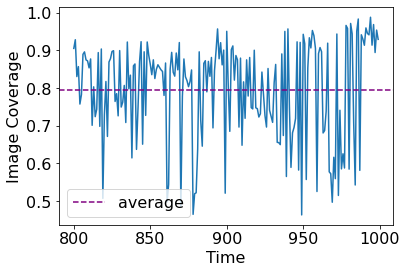

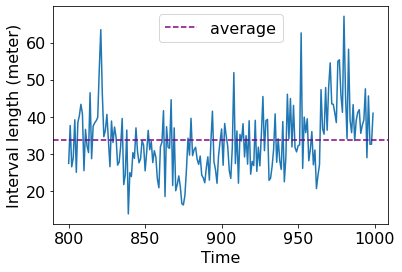

In [28]:
average_coverage = np.mean(coverages)
average_length = np.mean(lengths)
plt.plot(test_timestamps, coverages)
plt.xlabel("Time")
plt.ylabel("Image Coverage")
plt.axhline(y=average_coverage, color='purple', linestyle='--', label = 'average')
plt.legend()
plt.show()

plt.plot(test_timestamps, lengths)
plt.xlabel("Time")
plt.ylabel("Interval length (meter)")
plt.axhline(y=average_length, color='purple', linestyle='--', label = 'average')
plt.legend()
plt.show()